<a href="https://colab.research.google.com/github/Sowmya-Dadheech/Time_Series_Analysis_Mini_project/blob/main/Mini_Project_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

#EDA

In [ ]:
raw_df = pd.read_csv("/content/air-traffic-passenger-statistics.csv")
df = raw_df.copy()

In [ ]:
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090


In [ ]:
df.tail()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
18880,201806,WOW Air,WW,WOW Air,WW,International,Europe,Enplaned,Other,International,G,50
18881,201806,WestJet Airlines,WS,WestJet Airlines,WS,International,Canada,Deplaned,Other,International,A,10868
18882,201806,WestJet Airlines,WS,WestJet Airlines,WS,International,Canada,Enplaned,Other,International,A,11664
18883,201806,XL Airways France,SE,XL Airways France,SE,International,Europe,Deplaned,Other,International,A,804
18884,201806,XL Airways France,SE,XL Airways France,SE,International,Europe,Enplaned,Other,International,A,1243


In [ ]:
shape = df.shape

In [ ]:
columns = df.columns
n_columns = len(columns)

In [ ]:
nulls = df.isnull().sum().to_frame()
nulls.columns = ["Missing values"]
nulls

,Missing values
Activity Period,0
Operating Airline,0
Operating Airline IATA Code,63
Published Airline,0
Published Airline IATA Code,63
GEO Summary,0
GEO Region,0
Activity Type Code,0
Price Category Code,0
Terminal,0


#Dataset

- No of Rows = 18885
- No of Features = 12



#Preprocessing

##Time column formatting

In [ ]:
df.loc[:,"Activity Period"] = pd.to_datetime(df.loc[:,"Activity Period"].astype(str), format="%Y%m")
df.loc[:,"Year"] = df["Activity Period"].dt.year
df.loc[:,"Month"] = df["Activity Period"].dt.month

In [ ]:
time_begin = df.loc[:,"Activity Period"].min()
time_end = df.loc[:,"Activity Period"].max()
time_range = time_end-time_begin

print("First date: ", str(time_begin)[:11])
print("Last date: ", str(time_end)[:11])
print("Time range in days:", time_range.days)


First date:  2005-07-01 
Last date:  2018-06-01 
Time range in days: 4718


##Airline traffic generation

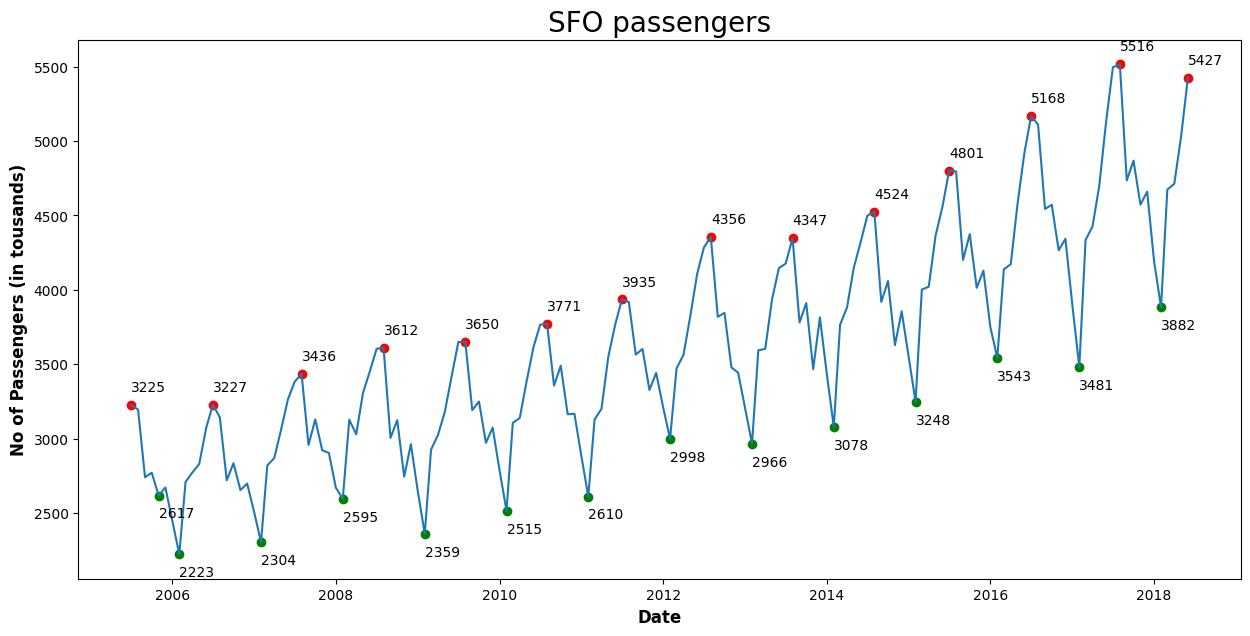

In [ ]:
df_yr = df.groupby(["Activity Period"])["Passenger Count"].sum().divide(1000)

fig, ax = plt.subplots(figsize=(15,7))

sns.lineplot(x=df_yr.index, y=df_yr.values, markers=True, ax=ax)

df_yr_maxs = df_yr.groupby(df_yr.index.year).max()
df_yr_max_complete = df_yr[df_yr.isin(df_yr_maxs.values)].to_frame()

plt.scatter(df_yr_max_complete.index, df_yr_max_complete.values, color = "red")

for t,v in df_yr_max_complete.reset_index().values:
    ax.text(t,v+90,int(v))

# Looking for minimum df for each year
df_yr_mins = df_yr.groupby(df_yr.index.year).min()
df_yr_min_complete = df_yr[df_yr.isin(df_yr_mins.values)].to_frame()
plt.scatter(df_yr_min_complete.index, df_yr_min_complete.values, color = "green")
for t,v in df_yr_min_complete.reset_index().values:
    ax.text(t,v-150,int(v))

plt.title("SFO passengers", size = 20)
plt.xlabel("Date", fontweight="bold", size = 12)
plt.ylabel("No of Passengers (in tousands)", fontweight="bold", size = 12)
plt.show()

The number of passengers is generally increasing (trend) with a clear seasonal pattern with a period of about one year. The traffic peak is around summertime while the lowest traffic is during wintertime at the beginning of the year.
The heatmap below shows what amount of traffic various airlines generated through the years (in thousands).

In [ ]:
df_airline_yr = df.groupby(["Year","Operating Airline"])["Passenger Count"].sum().divide(1000)
df_airline_yr = df_airline_yr.reset_index()
df_airline_yr

,Year,Operating Airline,Passenger Count
0,2005,ATA Airlines,277.540
1,2005,Air Canada,308.746
2,2005,Air Canada Jazz,1.063
3,2005,Air China,54.421
4,2005,Air France,119.337
...,...,...,...
664,2018,Virgin Atlantic,140.216
665,2018,Volaris Airlines,40.188
666,2018,WOW Air,61.859
667,2018,WestJet Airlines,45.259


##Merging data for UA (pre 7-1-2013)

In [ ]:
pivot_1 = df_airline_yr.pivot_table(values="Passenger Count", index="Operating Airline", columns="Year", fill_value=0)
pivot_1.loc["United Airlines",:] = pivot_1.loc["United Airlines",:] + pivot_1.loc["United Airlines - Pre 07/01/2013",:]
pivot_1.drop("United Airlines - Pre 07/01/2013",axis=0, inplace=True)

#dropping small airlines
smallest_airlines = pivot_1[pivot_1.sum(axis=1)<13]
pivot_1 = pivot_1.drop(smallest_airlines.index, axis=0)

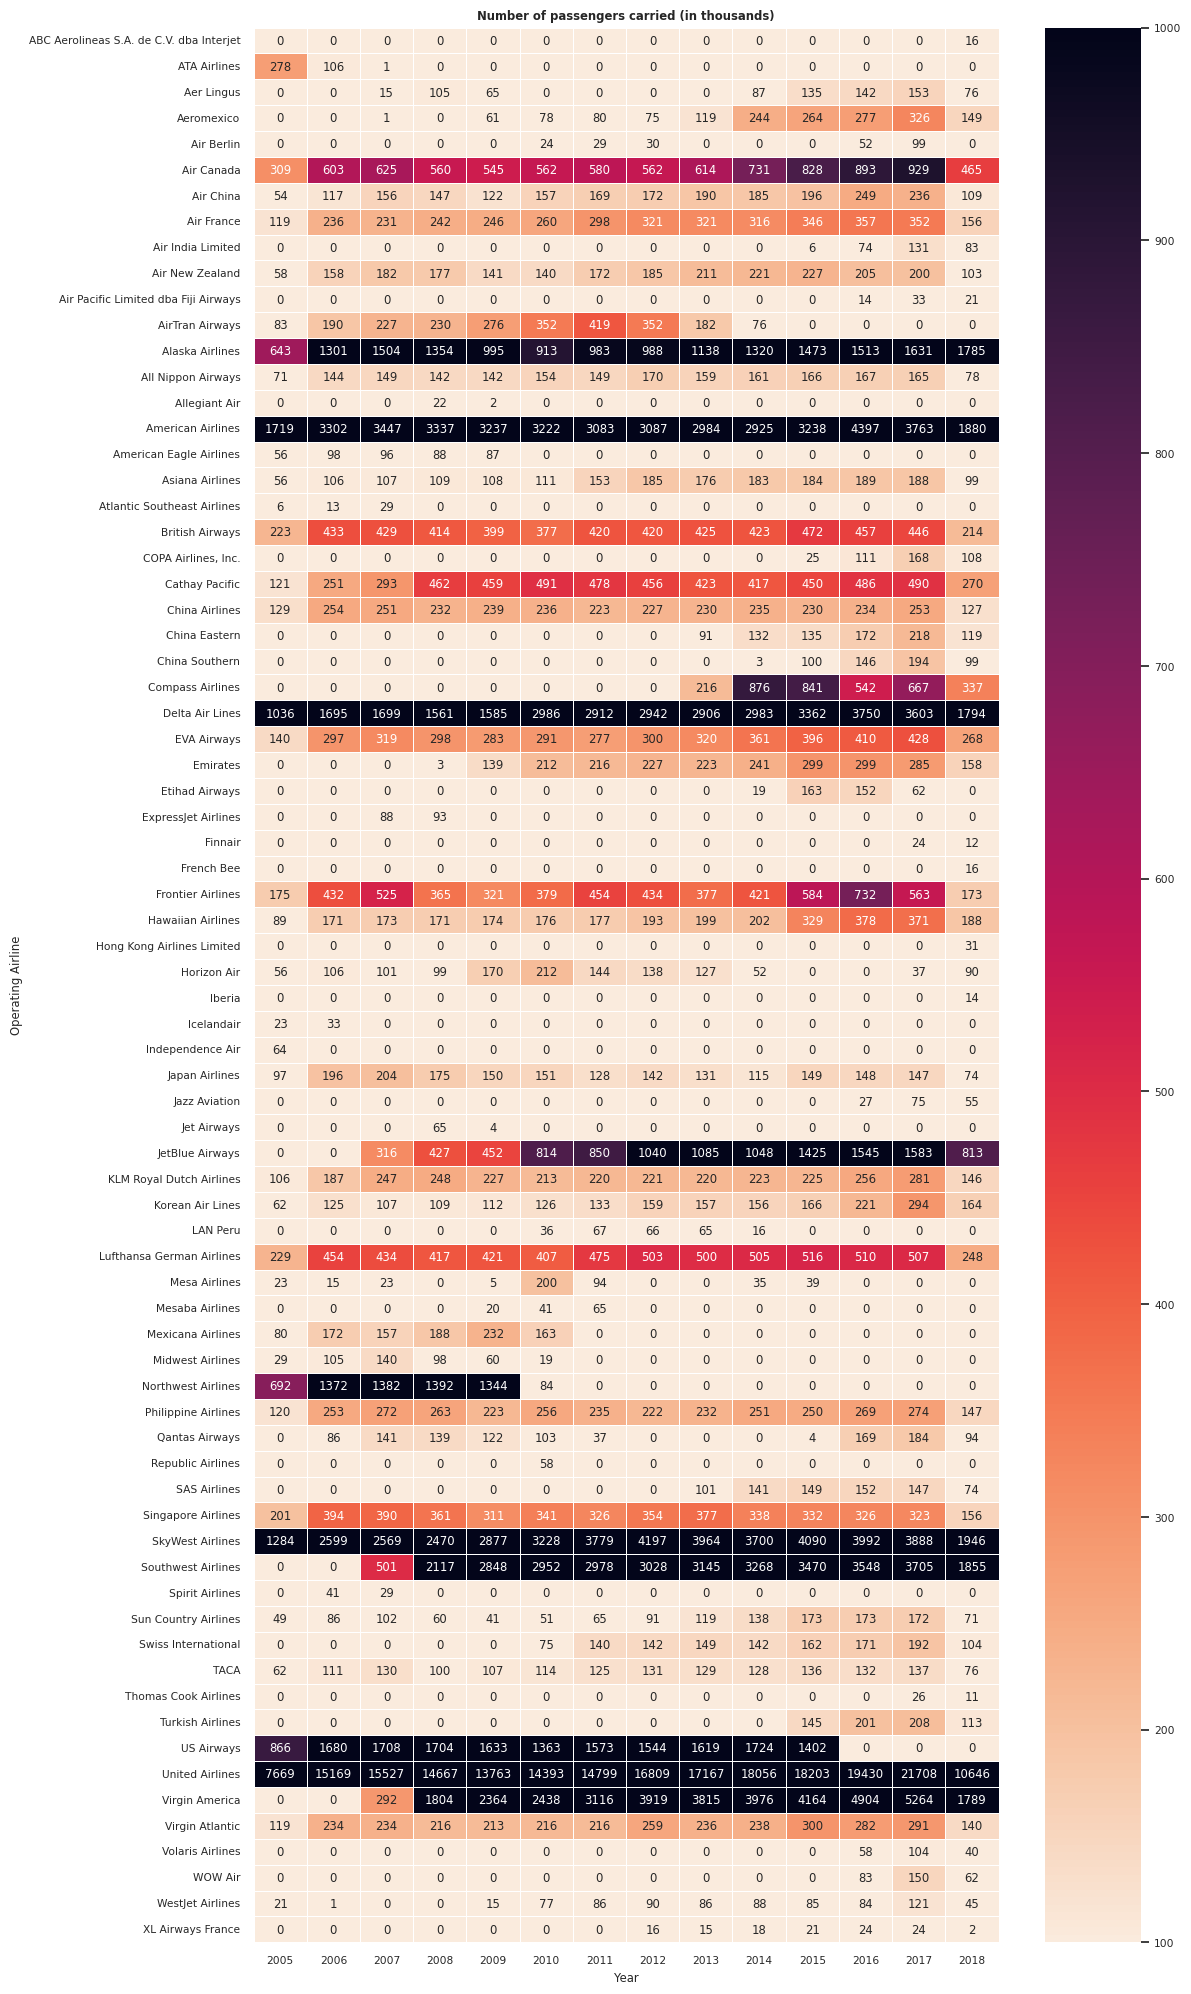

In [ ]:
sns.set(font_scale=0.7)
fig1 = plt.figure(figsize=(12,20))
p1 = sns.heatmap(pivot_1, annot=True, linewidths=.5, vmin=100, vmax=1000, fmt='.0f', cmap=sns.cm.rocket_r)
p1.set_title("Number of passengers carried (in thousands)", fontweight="bold")
plt.tight_layout()
plt.show()

##Find Airlines that generate the most of the traffic.
- To find that we have to find the mean number of passengers/airline every year.

In [ ]:
avg_airline = pivot_1.mean(axis=1)
TOP5_airlines = avg_airline.nlargest(5).to_frame().mul(1000).astype("int64")
TOP5_airlines.columns = ["Mean no. of passengers per year"]
sum_of_all = TOP5_airlines.loc[:,"Mean no. of passengers per year"].sum()
TOP5_airlines.loc[:,"Share [%]"] = TOP5_airlines.loc[:,"Mean no. of passengers per year"].div(sum_of_all).mul(100).round(1)
TOP5_airlines

,Mean no. of passengers per year,Share [%]
Operating Airline,,
United Airlines,15571737,57.5
SkyWest Airlines,3184454,11.8
American Airlines,3115884,11.5
Virgin America,2703137,10.0
Delta Air Lines,2486702,9.2


##TOP 5 BIGGEST AIRLINES

**1. United Airlines**

**2. SkyWest Airlines**

**3. American Airlines**

**4. Virgin America**

**5. Delta Airlines**


##Passanger traffic overview

Below there is a heatmap showing the number of passengers in each month (in thousands). We can see a peek in traffic around June-August.

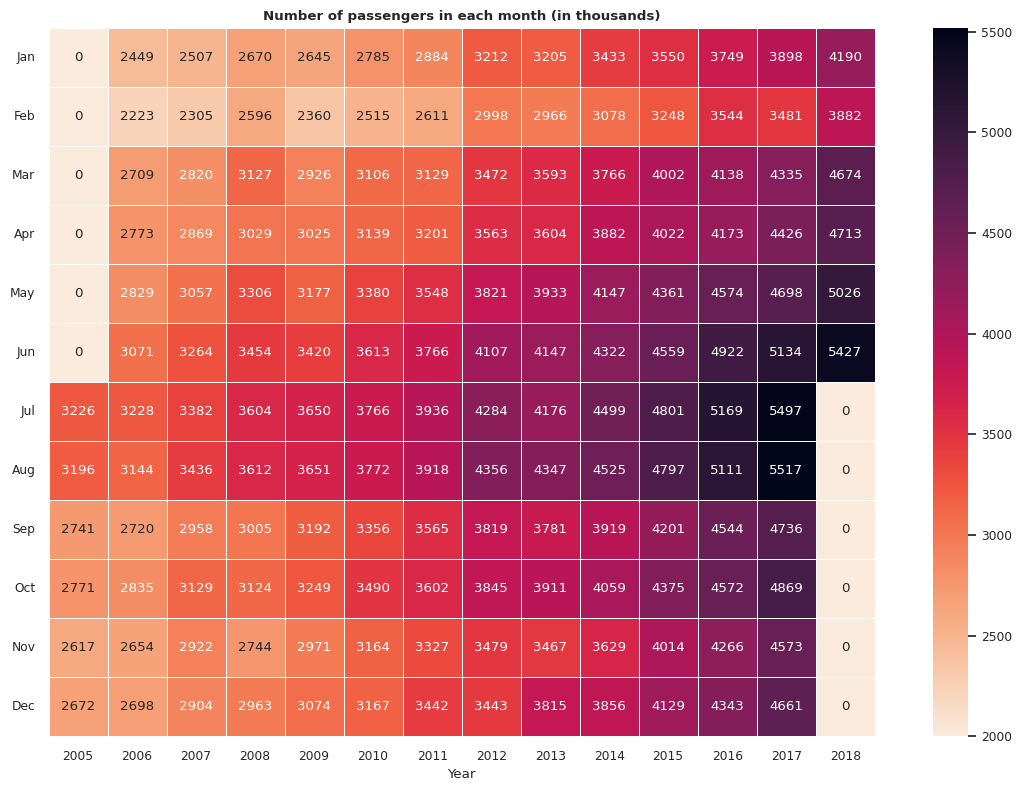

In [ ]:
df_month_yr = df.groupby(["Year","Month"])["Passenger Count"].sum().divide(1000).round()
df_month_yr = df_month_yr.reset_index()

pivot_2 = df_month_yr.pivot_table(values="Passenger Count",index="Month",columns="Year", fill_value=0)
pivot_2.index=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

sns.set(font_scale=0.8)
fig = plt.figure(figsize=(12,8))
g = sns.heatmap(pivot_2, annot=True, linewidths=.5, fmt="d", square =True, vmin=2000, cmap=sns.cm.rocket_r)
g.set_title("Number of passengers in each month (in thousands)", fontweight="bold")
g.set_yticklabels(g.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()

The line plot below shows the share of traffic being generated by each geographic region (excluding North America). The biggest share have Asia and Europe.

In [ ]:
TS2 = df[df["GEO Summary"]=="Domestic"].groupby("Activity Period")["Passenger Count"].sum()
TS3 = df[df["GEO Summary"]=="International"].groupby("Activity Period")["Passenger Count"].sum()

In [ ]:
TS2

Activity Period
2005-07-01    2425902
2005-08-01    2405904
2005-09-01    2067923
2005-10-01    2095119
2005-11-01    1998879
               ...   
2018-02-01    2963364
2018-03-01    3579413
2018-04-01    3630813
2018-05-01    3818359
2018-06-01    4039838
Name: Passenger Count, Length: 156, dtype: int64

In [ ]:
TS3

Activity Period
2005-07-01     799867
2005-08-01     789962
2005-09-01     672630
2005-10-01     675596
2005-11-01     618454
               ...   
2018-02-01     918817
2018-03-01    1094622
2018-04-01    1082370
2018-05-01    1207236
2018-06-01    1387306
Name: Passenger Count, Length: 156, dtype: int64

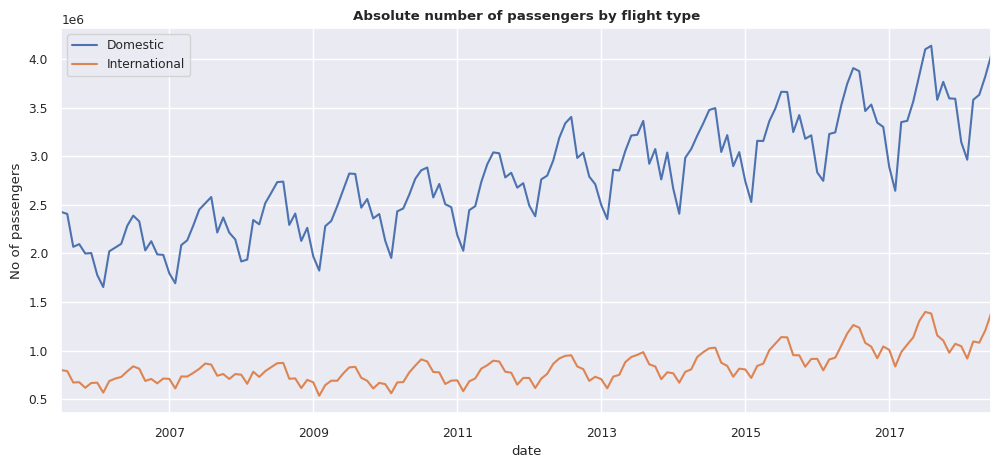

In [ ]:
TS = pd.concat([TS2,TS3],axis=1)
TS.columns=["Domestic","International"]

ax = TS.plot(figsize=(12,5))
ax.set_title("Absolute number of passengers by flight type", fontweight="bold")
ax.set_xlabel('date')
ax.set_ylabel('No of passengers')
plt.show()

# Time Series Analysis


The plot below shows overall traffic on the airport over time. It looks like it is linear but a trends and seasonlity sgould be removeed

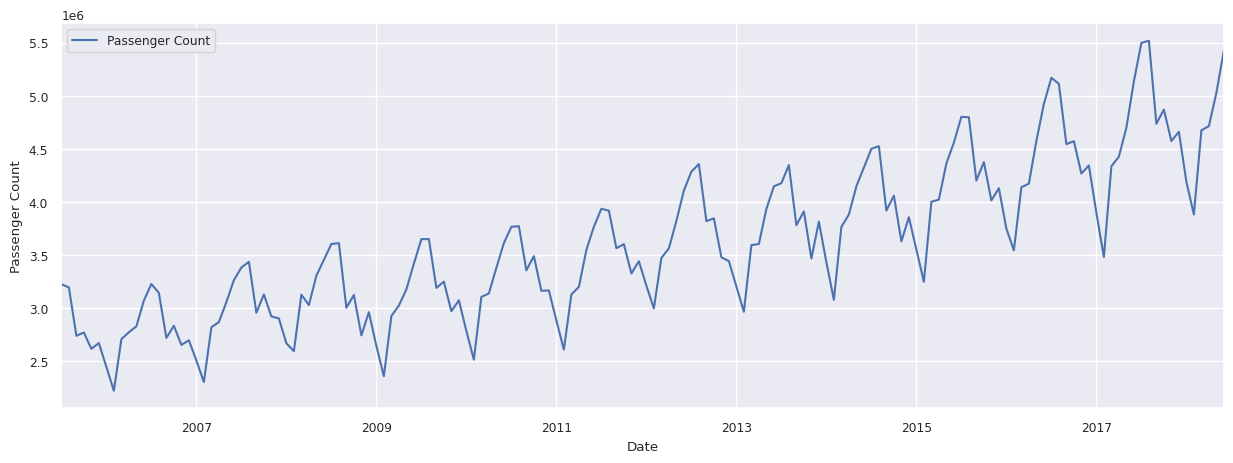

In [ ]:
TS1 = df.groupby("Activity Period")["Passenger Count"].sum().to_frame()

fig, ax = plt.subplots(1,1,figsize=(15,5))
TS1.plot(ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Passenger Count")
plt.grid(True)
plt.show()

#Time Series Forecasting

##Functions

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00


In [ ]:
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series, column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MSE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

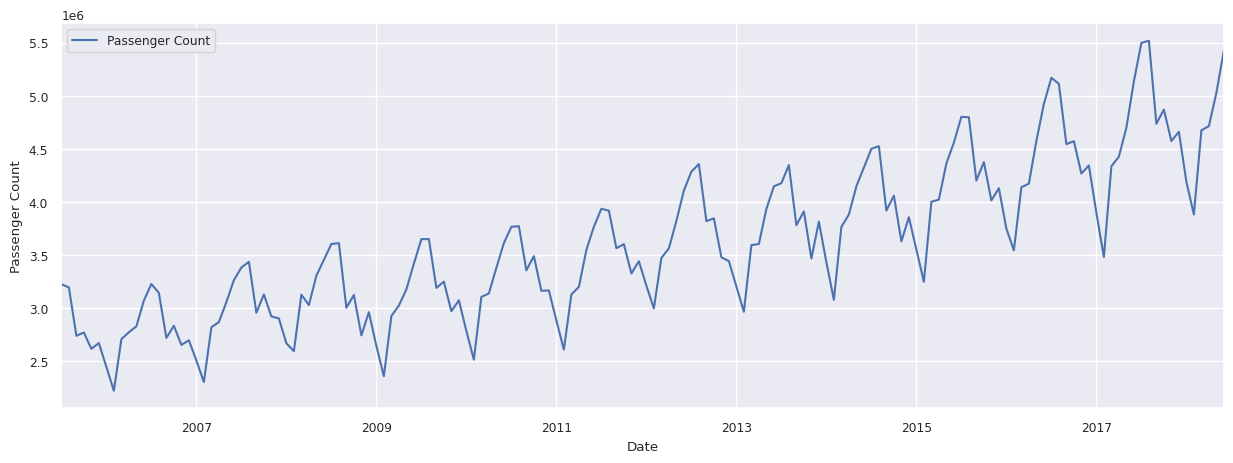

In [ ]:
TS1 = df.groupby("Activity Period")["Passenger Count"].sum().to_frame()

fig, ax = plt.subplots(1,1,figsize=(15,5))
TS1.plot(ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Passenger Count")
plt.grid(True)
plt.show()

The Augmented Dickey-Fuller test can be used to test for stationarity of our time series. The null hypothesis of the test is that the time series is not stationary (has some time-dependent structure).
* **Null Hypothesis (H0):** if failed to be rejected (high p-value) means it is non-stationary
* **Null Hypothesis (H1):** if H0 is rejected (low p-value) means it is stationary

In [ ]:
Augmented_Dickey_Fuller_Test_func(TS1["Passenger Count"],'Passenger Count')

Results of Dickey-Fuller Test for column: Passenger Count
Test Statistic                   1.133106
p-value                          0.995489
No Lags Used                    14.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


##P-value is 0.99
 - Time series is not stationary.

###Decompose it into 3 main components:
* trend
* seasonality
* residuals

<Figure size 1000x500 with 0 Axes>

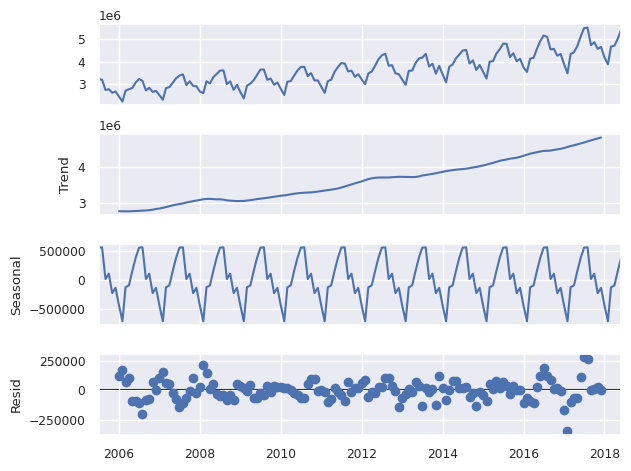

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(10, 5))
decomposed_add = seasonal_decompose(TS1, model="additive")
add = decomposed_add.plot()
plt.show()

##Now apply differencing step


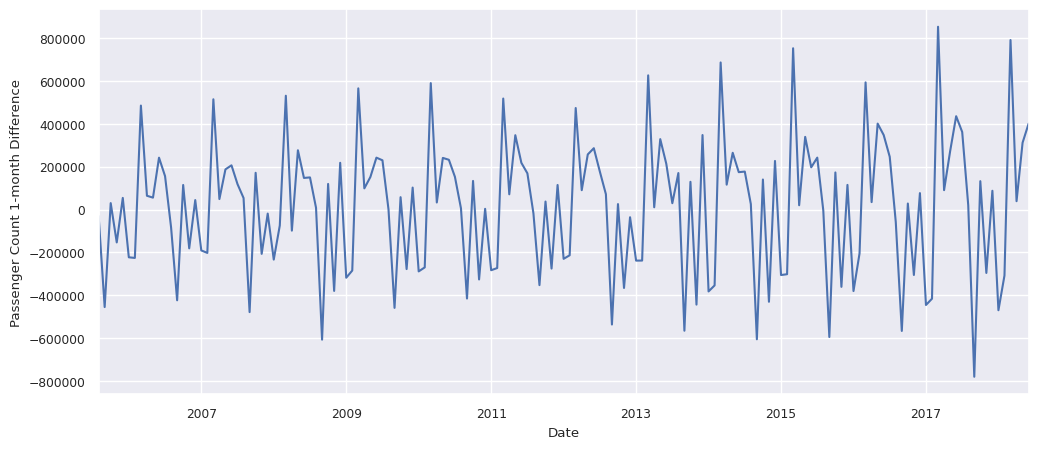

In [ ]:
TS1_diff = TS1.diff().dropna()

plt.figure(figsize=(12,5))
ax = TS1_diff["Passenger Count"].plot()
ax.set_xlabel("Date")
ax.set_ylabel("Passenger Count 1-month Difference")
plt.grid(True)
plt.show()

In [ ]:
Augmented_Dickey_Fuller_Test_func(TS1_diff["Passenger Count"],'Passenger Count')

Results of Dickey-Fuller Test for column: Passenger Count
Test Statistic                  -2.950493
p-value                          0.039784
No Lags Used                    13.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary



* **AutoCorrelation Plot** (ACF)
* **Partial AutoCorrelation Plot** (PACF)

In [ ]:
TS1_diff

,Passenger Count
Activity Period,
2005-08-01,-29903.0
2005-09-01,-455313.0
2005-10-01,30162.0
2005-11-01,-153382.0
2005-12-01,54464.0
...,...
2018-02-01,-308186.0
2018-03-01,791854.0
2018-04-01,39148.0


##Train Test Split

In [ ]:
X = TS1_diff['Passenger Count']
train = X.iloc[:-30]
test = X.iloc[-30:]

##AIC BIC for determining p,q

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
AIC_BIC=[]

for p in range(7):
    for q in range(7):
        model = SARIMAX(train, order=(p,1,q), freq=train.index.inferred_freq) # take d=1
        results = model.fit()
        AIC_BIC.append((p,q,results.aic, results.bic))

order_df = pd.DataFrame(AIC_BIC,
                        columns=['p','q','AIC','BIC'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

In [ ]:
order_df.sort_values('AIC').head()

,p,q,AIC,BIC
45,6,3,3369.128190,3397.331006
48,6,6,3380.780836,3417.444496
47,6,5,3382.456376,3416.299755
44,6,2,3390.598808,3415.981342
46,6,4,3395.939671,3426.962768


In [ ]:
order_df.sort_values('BIC').head()

,p,q,AIC,BIC
45,6,3,3369.128190,3397.331006
44,6,2,3390.598808,3415.981342
47,6,5,3382.456376,3416.299755
48,6,6,3380.780836,3417.444496
43,6,1,3399.129833,3421.692085


##ARIMA AIC BIC

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

TS1.index.freq = TS1.index.inferred_freq
model2 = SARIMAX(train, order=(6,1,3))
results = model2.fit()
results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Passenger Count   No. Observations:                  125
Model:               SARIMAX(6, 1, 3)   Log Likelihood               -1674.564
Date:                Tue, 05 Dec 2023   AIC                           3369.128
Time:                        03:06:06   BIC                           3397.331
Sample:                    08-01-2005   HQIC                          3380.585
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0371      0.176     -0.211      0.833      -0.381       0.307
ar.L2          0.1326      0.142      0.930      0.352      -0.147       0.412
ar.L3          0.0499      0.118      0.421      0.674      -0.182       0.282
ar.L4         -0.1181      0.109     -1.086      0.277      -0.331       0.095
ar.L5         -0.0672      0.128     -0.527      0.598      -0.317       0.183
ar.L6         -0.7335      0.107     -6.846      0.000      -0.944      -0.523
ma.L1         -1.3806      0.238     -5.796      0.000      -1.847      -0.914
ma.L2          0.0618      0.461      0.134      0.893      -0.842       0.966
ma.L3          0.3320      0.247      1.342      0.180      -0.153       0.817
sigma2      4.159e+10   7.24e-12   5.74e+21      0.000    4.16e+10    4.16e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.75   Prob(JB):                         0.59
Heteroskedasticity (H):               1.38   Skew:                             0.05
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.69e+38. Standard errors may be unstable.
"""

<Figure size 1200x800 with 0 Axes>

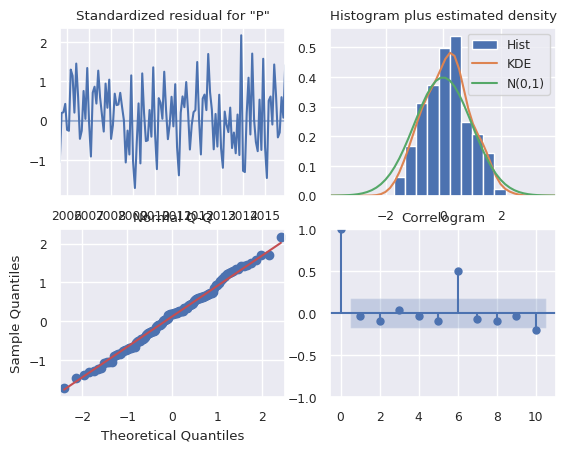

In [ ]:
plt.figure(figsize=(12,8))
plot = results.plot_diagnostics()
plt.show()

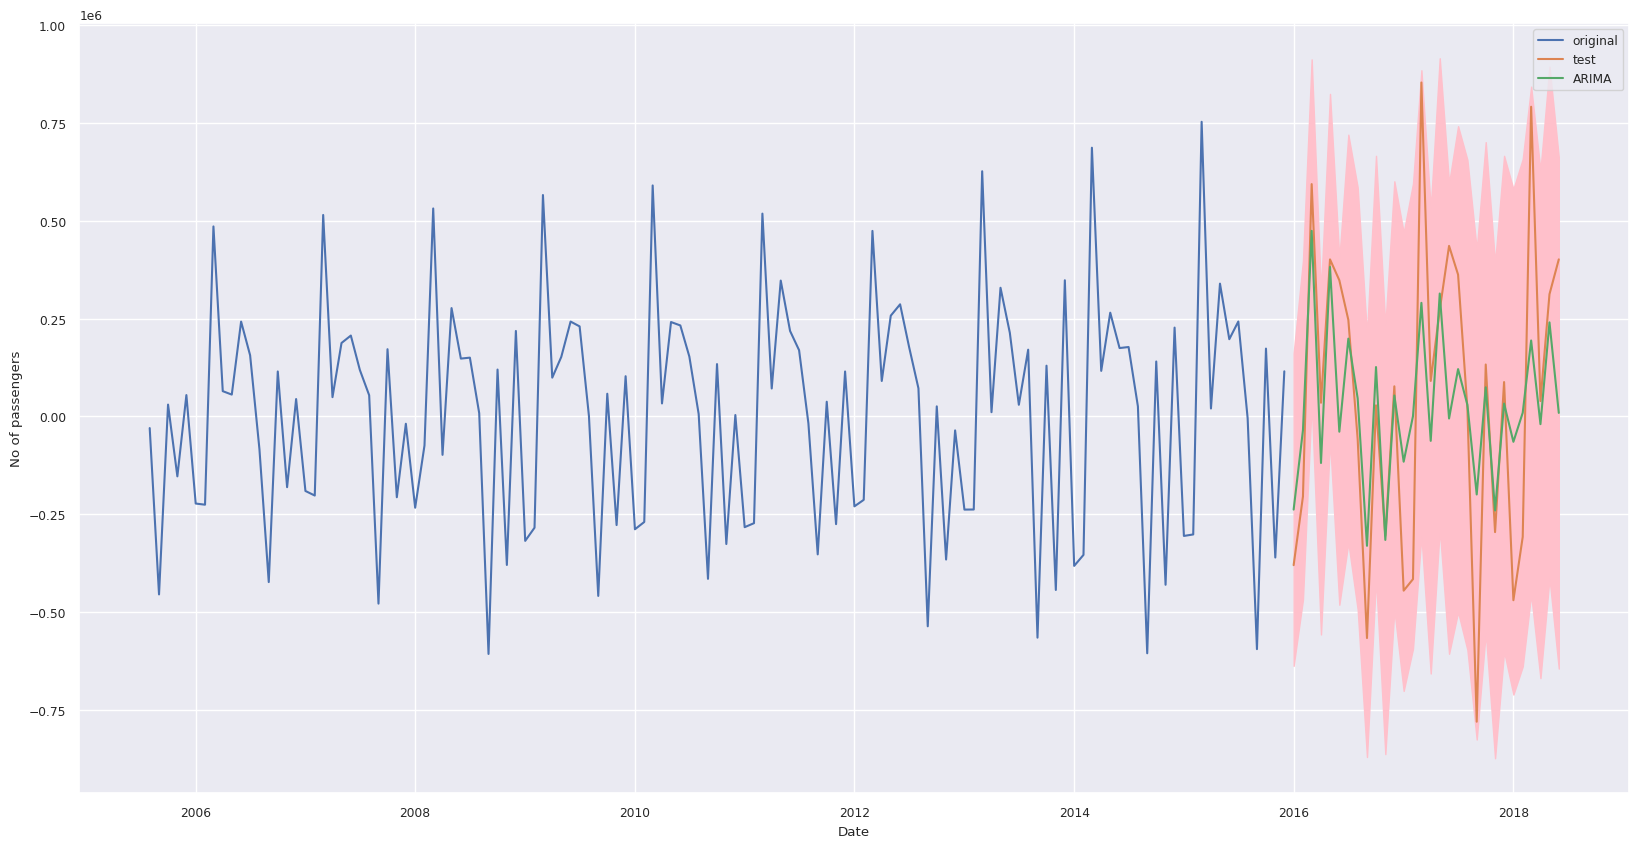

In [ ]:
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower Passenger Count"]
upper = forecast.conf_int()["upper Passenger Count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(train, label='original')
plt.plot(test, label='test')
plt.plot(forecast.predicted_mean, label='ARIMA', c="g")
plt.fill_between(forecast.conf_int().index,
                 lower,upper,
                 color='pink')
plt.xlabel('Date')
plt.ylabel('No of passengers')
plt.legend()
plt.show()

In [ ]:
timeseries_evaluation_metrics_func(test,forecast.predicted_mean)

Evaluation metric results:-
MSE is : 77573554884.73354
MSE is : 210097.84926106984
RMSE is : 278520.2952833663
MAPE is : 89.76751906412697
R2 is : 0.503147682833478



The plot above shows predictions using SARIMAX(6,1,3)x(0,1,0,12). The red line indicates the mean and the pink area is bounded by 95% confidence intervals.

##SARIMA AIC BIC

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

TS1.index.freq = TS1.index.inferred_freq
model2 = SARIMAX(train, order=(6,1,3), seasonal_order=(0,1,0,12))
results = model2.fit()
results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     Passenger Count   No. Observations:                  125
Model:             SARIMAX(6, 1, 3)x(0, 1, [], 12)   Log Likelihood               -1429.308
Date:                             Tue, 05 Dec 2023   AIC                           2878.616
Time:                                     03:06:10   BIC                           2905.801
Sample:                                 08-01-2005   HQIC                          2889.646
                                      - 12-01-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3545      0.590     -2.294      0.022      -2.512      -0.197
ar.L2         -0.7103      0.782     -0.908      0.364      -2.243       0.822
ar.L3         -0.1795      0.343     -0.524      0.600      -0.851       0.492
ar.L4          0.1458      0.214      0.683      0.495      -0.273       0.565
ar.L5          0.0818      0.248      0.330      0.741      -0.404       0.568
ar.L6         -0.1355      0.193     -0.704      0.482      -0.513       0.242
ma.L1          0.0656      0.639      0.103      0.918      -1.187       1.318
ma.L2         -0.7880      0.220     -3.577      0.000      -1.220      -0.356
ma.L3         -0.2679      0.587     -0.457      0.648      -1.418       0.882
sigma2      8.166e+09   1.04e-10   7.86e+19      0.000    8.17e+09    8.17e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.12
Prob(Q):                              0.96   Prob(JB):                         0.01
Heteroskedasticity (H):               0.91   Skew:                             0.12
Prob(H) (two-sided):                  0.78   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.3e+35. Standard errors may be unstable.
"""

<Figure size 1200x800 with 0 Axes>

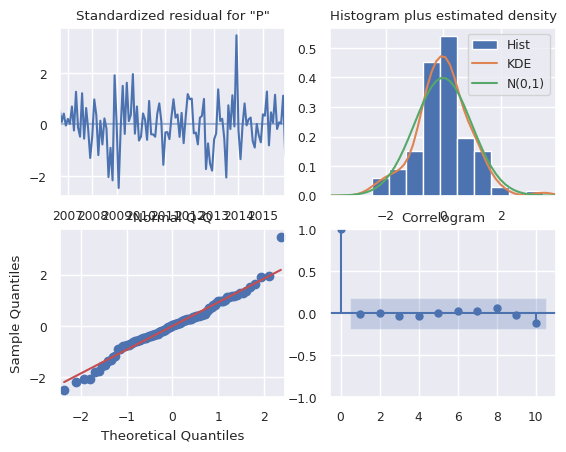

In [ ]:
plt.figure(figsize=(12,8))
plot = results.plot_diagnostics()
plt.show()

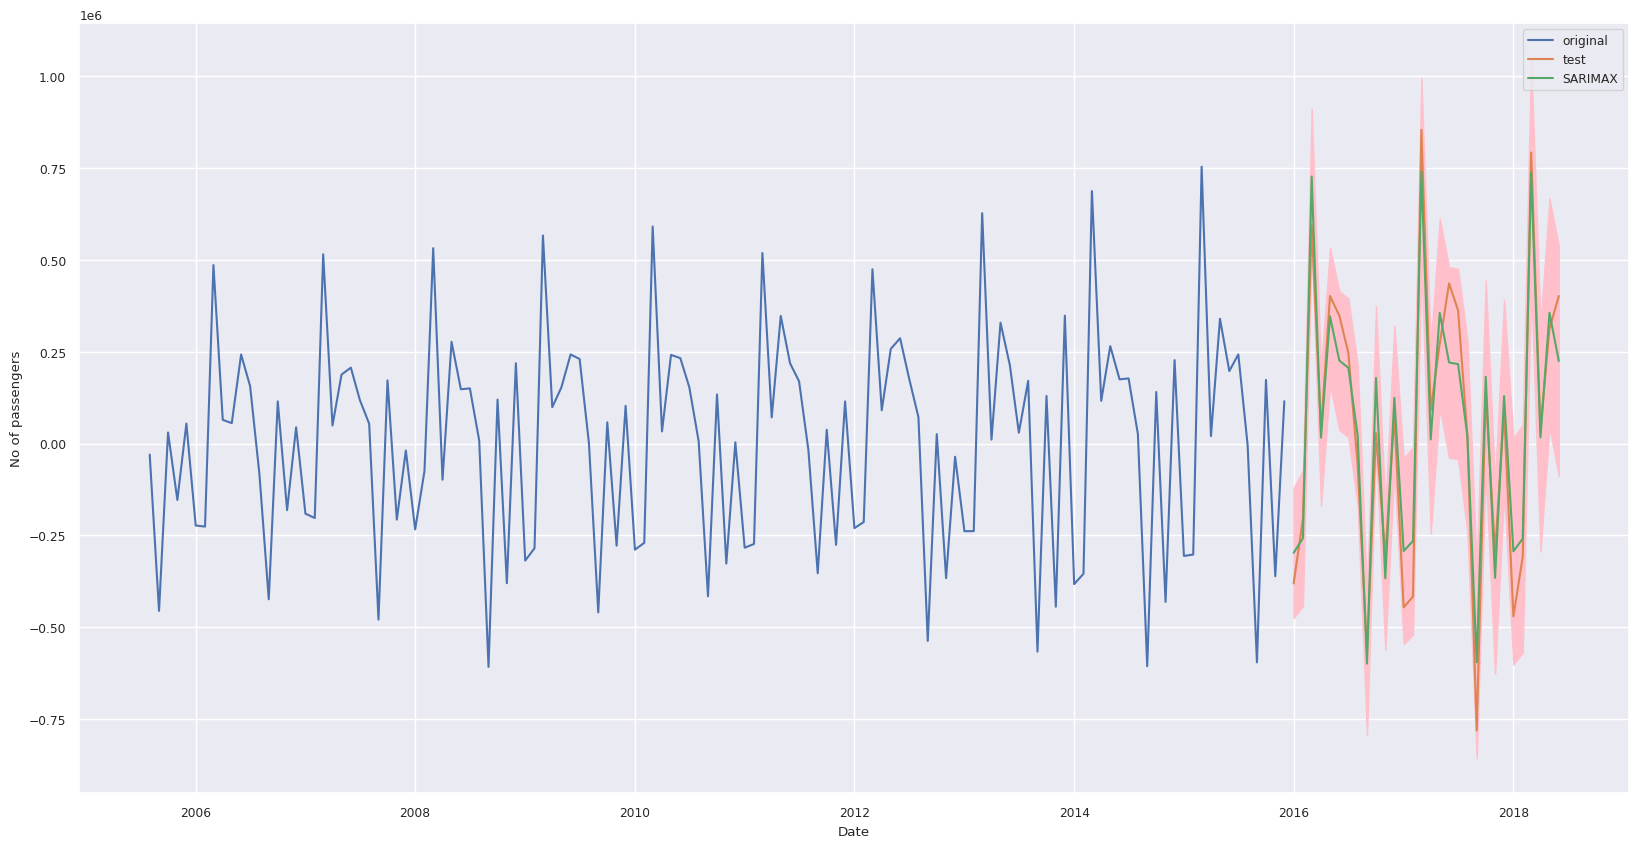

In [ ]:
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower Passenger Count"]
upper = forecast.conf_int()["upper Passenger Count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(train, label='original')
plt.plot(test, label='test')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="g")
plt.fill_between(forecast.conf_int().index,
                 lower,upper,
                 color='pink')
plt.xlabel('Date')
plt.ylabel('No of passengers')
plt.legend()
plt.show()

In [ ]:
timeseries_evaluation_metrics_func(test,forecast.predicted_mean)

Evaluation metric results:-
MSE is : 11251337592.395853
MSE is : 89587.96595879254
RMSE is : 106072.32246159152
MAPE is : 51.569735477419975
R2 is : 0.9279360967495788



##ACF PACF

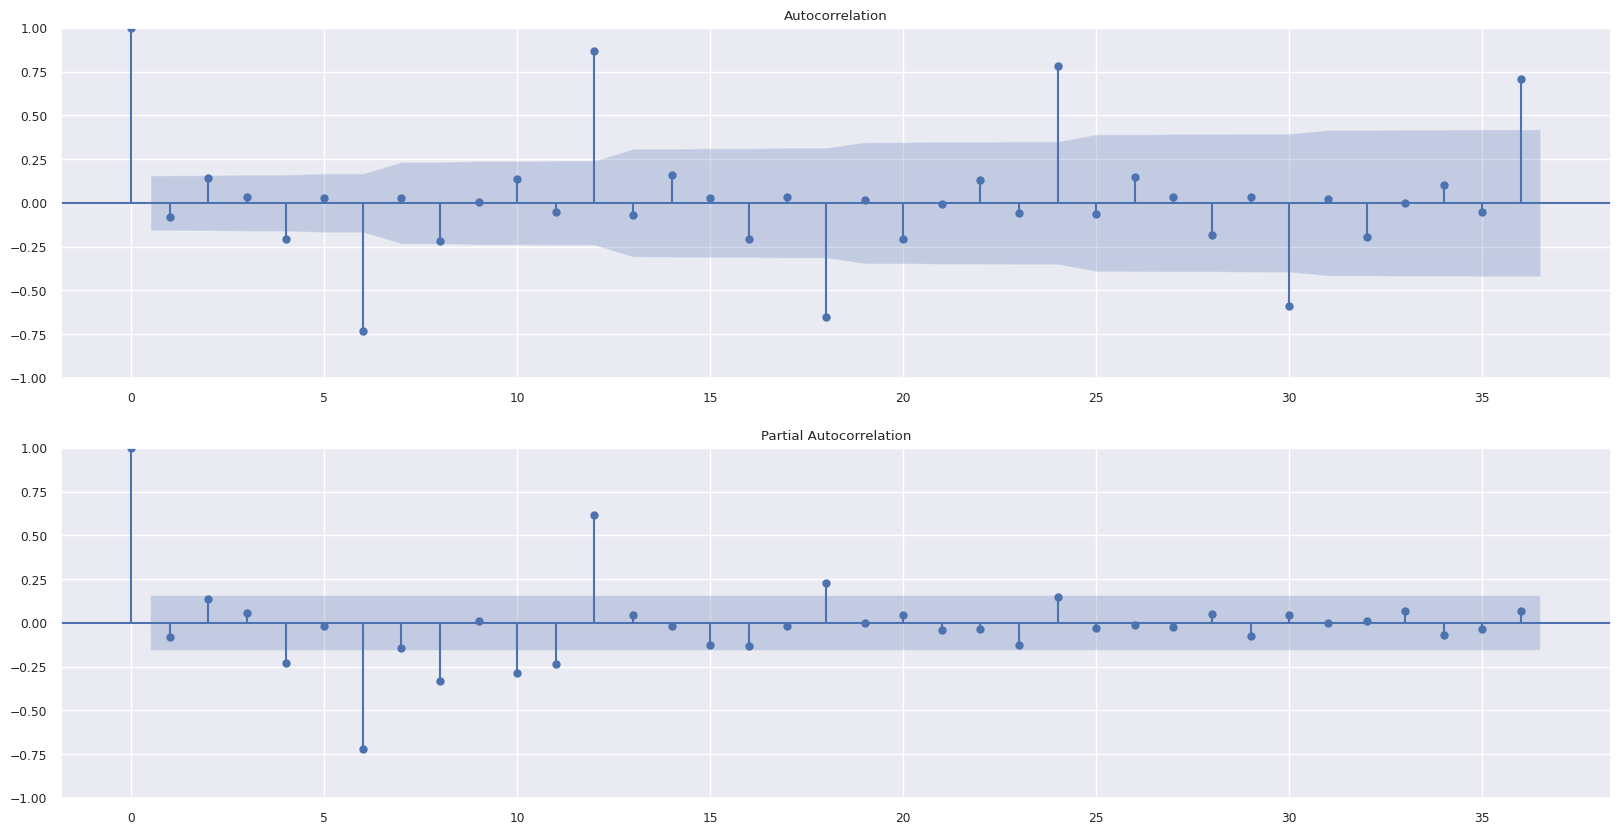

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(TS1_diff, lags=36, ax=ax[0])
plot_pacf(TS1_diff, lags=36, ax=ax[1])
plt.show()

##ARIMA ACF PACF

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

TS1.index.freq = TS1.index.inferred_freq
ARIMA = SARIMAX(train, order=(2,1,1))
result = ARIMA.fit()
result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Passenger Count   No. Observations:                  125
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1748.056
Date:                Tue, 05 Dec 2023   AIC                           3504.113
Time:                        03:06:14   BIC                           3515.394
Sample:                    08-01-2005   HQIC                          3508.695
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6692      0.501     -1.337      0.181      -1.650       0.312
ar.L2         -0.2133      0.287     -0.744      0.457      -0.775       0.349
ma.L1         -0.2008      0.535     -0.375      0.708      -1.250       0.848
sigma2      1.042e+11   1.45e-11    7.2e+21      0.000    1.04e+11    1.04e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 8.38
Prob(Q):                              0.94   Prob(JB):                         0.02
Heteroskedasticity (H):               1.71   Skew:                             0.24
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+38. Standard errors may be unstable.
"""

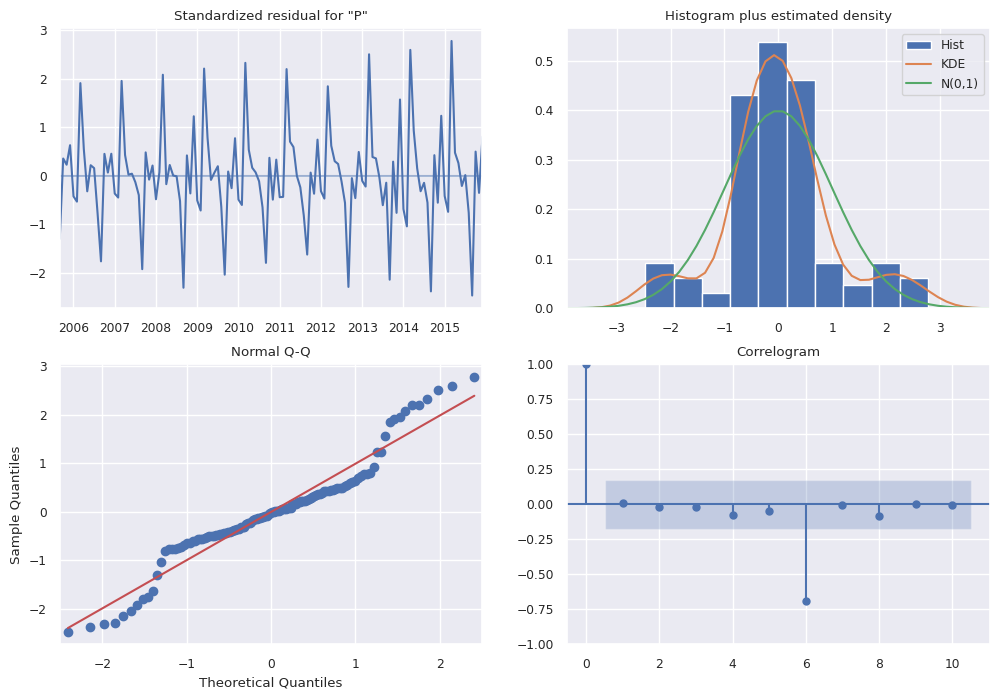

In [ ]:
plt.rcParams['figure.figsize'] = 12, 8
plot = result.plot_diagnostics()
plt.show()

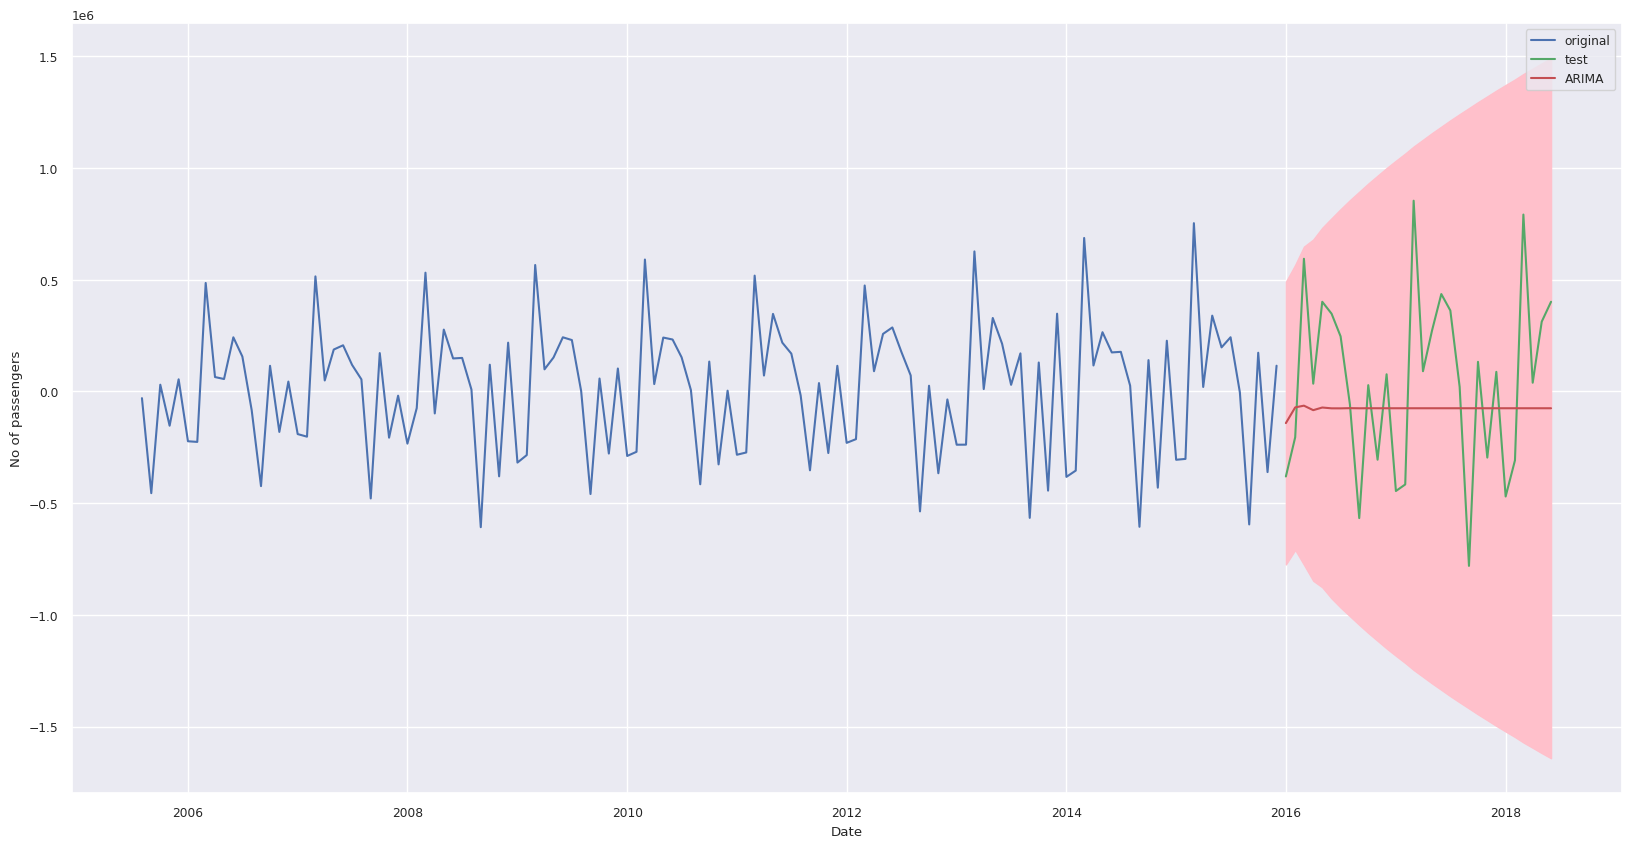

In [ ]:
forecast = result.get_forecast(steps=30)
lower = forecast.conf_int()["lower Passenger Count"]
upper = forecast.conf_int()["upper Passenger Count"]

fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(train, label='original')
plt.plot(test, label='test',c="g")
plt.plot(forecast.predicted_mean, label='ARIMA', c="r")
plt.fill_between(forecast.conf_int().index,
                 lower,upper,
                 color='pink')
plt.xlabel('Date')
plt.ylabel('No of passengers')
plt.legend()
plt.show()

In [ ]:
timeseries_evaluation_metrics_func(test,forecast.predicted_mean)

Evaluation metric results:-
MSE is : 168448549720.1739
MSE is : 344364.34937831596
RMSE is : 410424.84052524634
MAPE is : 143.58238125657385
R2 is : -0.07889927664355967



##SARIMA ACF PACF

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

TS1.index.freq = TS1.index.inferred_freq
SARIMA = SARIMAX(train, order=(2,1,1), seasonal_order=(0,1,0,12))
result1 = SARIMA.fit()
result1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     Passenger Count   No. Observations:                  125
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood               -1436.034
Date:                             Tue, 05 Dec 2023   AIC                           2880.069
Time:                                     03:06:16   BIC                           2890.943
Sample:                                 08-01-2005   HQIC                          2884.481
                                      - 12-01-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3616      0.150     -2.404      0.016      -0.656      -0.067
ar.L2         -0.1623      0.097     -1.672      0.094      -0.352       0.028
ma.L1         -0.9945      0.105     -9.512      0.000      -1.199      -0.790
sigma2      9.596e+09   1.04e-11   9.25e+20      0.000     9.6e+09     9.6e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.50
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.43
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+36. Standard errors may be unstable.
"""

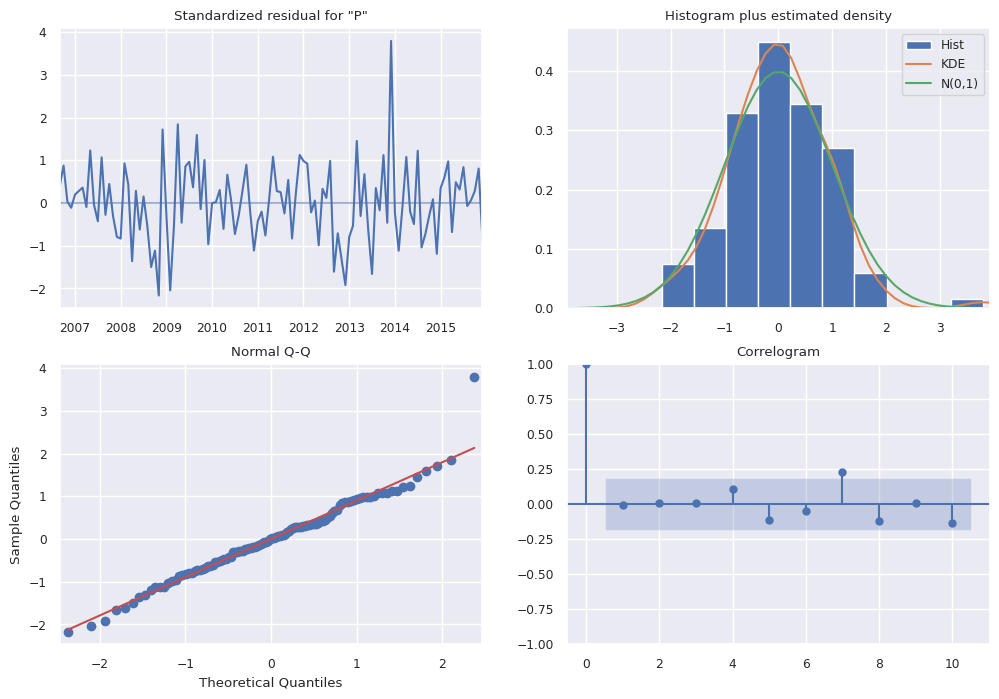

In [ ]:
plt.rcParams['figure.figsize'] = 12, 8
plot = result1.plot_diagnostics()
plt.show()

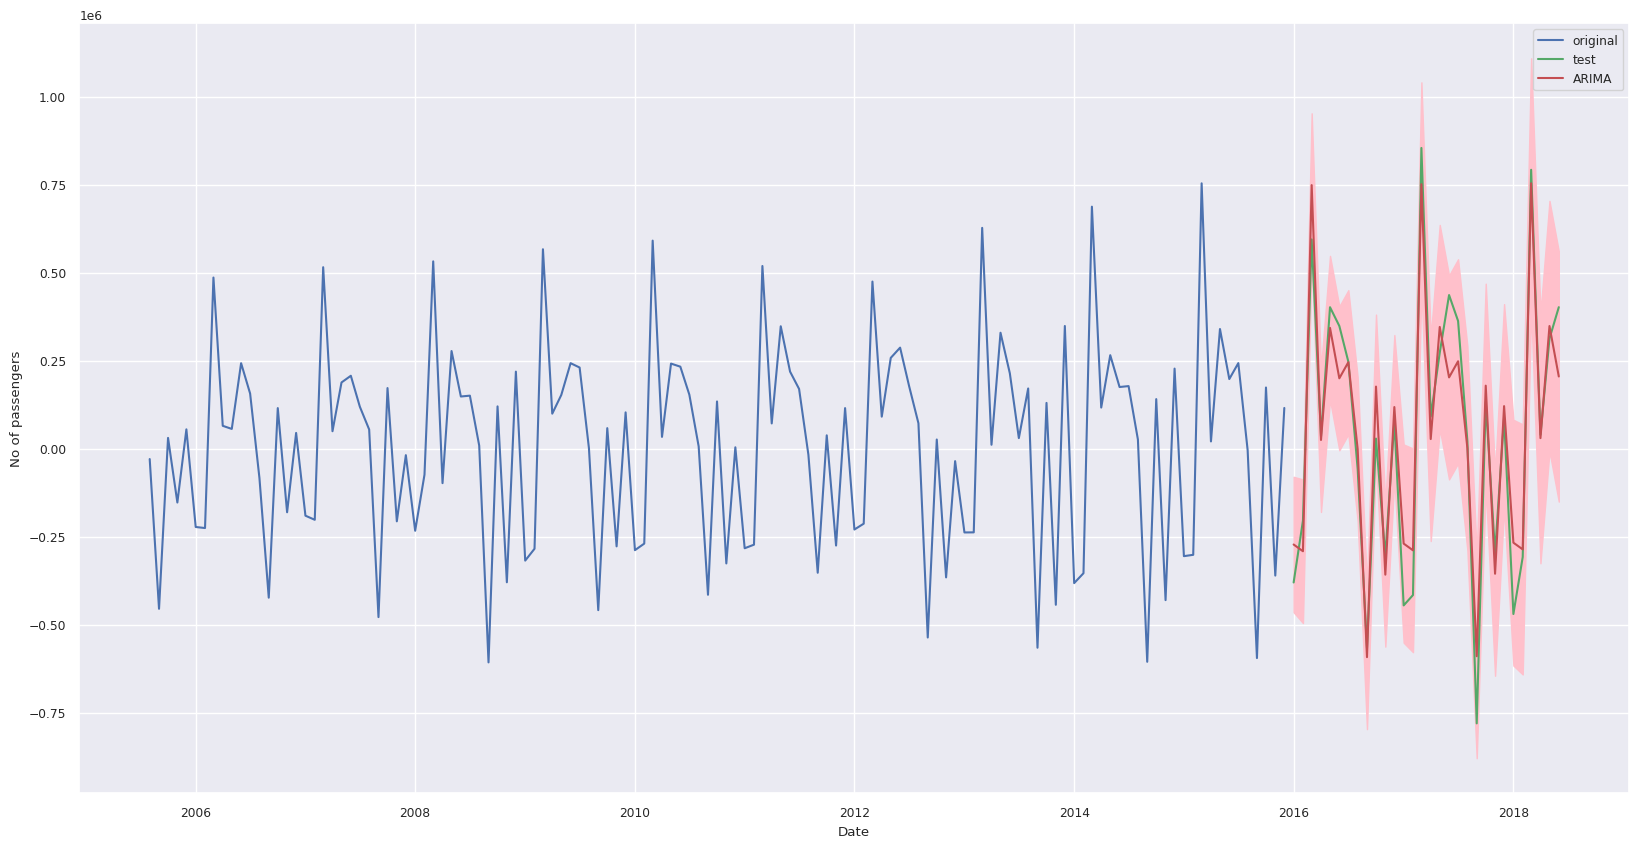

In [ ]:
forecast1 = result1.get_forecast(steps=30)
lower = forecast1.conf_int()["lower Passenger Count"]
upper = forecast1.conf_int()["upper Passenger Count"]

fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(train, label='original')
plt.plot(test, label='test',c="g")
plt.plot(forecast1.predicted_mean, label='ARIMA', c="r")
plt.fill_between(forecast1.conf_int().index,
                 lower,upper,
                 color='pink')
plt.xlabel('Date')
plt.ylabel('No of passengers')
plt.legend()
plt.show()

In [ ]:
timeseries_evaluation_metrics_func(test,forecast1.predicted_mean)

Evaluation metric results:-
MSE is : 12008927335.454603
MSE is : 87869.39460828374
RMSE is : 109585.25145043289
MAPE is : 49.894252316697425
R2 is : 0.9230837959898722



##CNN

In [ ]:
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

In [ ]:
def train_split_sequence(sequence, steps):
  X, y = list(), list()
  for start in range(0, len(sequence)-30):
    end_index = start + steps
    if end_index > len(sequence)-1:
      break
    sequence_x, sequence_y = sequence[start: end_index], sequence[end_index]
    X.append(sequence_x)
    y.append(sequence_y)
  return array(X), array(y)


def test_split_sequence(sequence, steps):
  X, y = list(), list()
  for start in range(len(sequence)-30, len(sequence)):
    end_index = start + steps
    if end_index > len(sequence)-1:
      break
    sequence_x, sequence_y = sequence[start: end_index], sequence[end_index]
    X.append(sequence_x)
    y.append(sequence_y)
  return array(X), array(y)

In [ ]:
raw_sequence = TS1_diff['Passenger Count']
steps = 30

X, y = train_split_sequence(raw_sequence, steps)

In [ ]:
print("**************************************")
print("The input to the CNN :\n", raw_sequence)
print("**************************************")
print("The features (X), lagged values of time series, for our CNN Model")
print(X)
print("**************************************")
print("The respective observed values (y) of sequence for training our CNN Model")
print(y)
print("**************************************")

**************************************
The input to the CNN :
 Activity Period
2005-08-01    -29903.0
2005-09-01   -455313.0
2005-10-01     30162.0
2005-11-01   -153382.0
2005-12-01     54464.0
                ...   
2018-02-01   -308186.0
2018-03-01    791854.0
2018-04-01     39148.0
2018-05-01    312412.0
2018-06-01    401549.0
Name: Passenger Count, Length: 155, dtype: float64
**************************************
The features (X), lagged values of time series, for our CNN Model
[[ -29903. -455313.   30162. ... -206809.  -18863. -233584.]
 [-455313.   30162. -153382. ...  -18863. -233584.  -74377.]
 [  30162. -153382.   54464. ... -233584.  -74377.  531711.]
 ...
 [ 173355. -360935.  115238. ... -470137. -308186.  791854.]
 [-360935.  115238. -380523. ... -308186.  791854.   39148.]
 [ 115238. -380523. -204890. ...  791854.   39148.  312412.]]
**************************************
The respective observed values (y) of sequence for training our CNN Model
[ -74377.  531711.  -98366.

In [ ]:
features = 1
X = X.reshape((X.shape[0], X.shape[1], features))

print("After reshaping, the shape of input X")
print(X.shape)
print("**************************************")
print("**************************************")
print("The final form of input feature matrix X is")
print(X)
print("**************************************")
print("**************************************")
print("Feature matrix X is ready for input to CNN model. We have used feature engineering to convert\n"
,"a sequence to matrix with image matrix shape to find patterns in sequence")
print("**************************************")
print("**************************************")

After reshaping, the shape of input X
(125, 30, 1)
**************************************
**************************************
The final form of input feature matrix X is
[[[ -29903.]
  [-455313.]
  [  30162.]
  ...
  [-206809.]
  [ -18863.]
  [-233584.]]

 [[-455313.]
  [  30162.]
  [-153382.]
  ...
  [ -18863.]
  [-233584.]
  [ -74377.]]

 [[  30162.]
  [-153382.]
  [  54464.]
  ...
  [-233584.]
  [ -74377.]
  [ 531711.]]

 ...

 [[ 173355.]
  [-360935.]
  [ 115238.]
  ...
  [-470137.]
  [-308186.]
  [ 791854.]]

 [[-360935.]
  [ 115238.]
  [-380523.]
  ...
  [-308186.]
  [ 791854.]
  [  39148.]]

 [[ 115238.]
  [-380523.]
  [-204890.]
  ...
  [ 791854.]
  [  39148.]
  [ 312412.]]]
**************************************
**************************************
Feature matrix X is ready for input to CNN model. We have used feature engineering to convert
 a sequence to matrix with image matrix shape to find patterns in sequence
**************************************
*******************

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(steps, features)))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 100)               89700     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 89993 (351.54 KB)
Trainable params: 89993 (351.54 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
model.compile(optimizer="adam", loss="mse")

In [ ]:
model.fit(X, y, epochs=50, verbose=1)

Epoch 1/50
4/4 [==============================] - 1s 8ms/step - loss: 82394406912.0000
Epoch 2/50
4/4 [==============================] - 0s 6ms/step - loss: 40203071488.0000
Epoch 3/50
4/4 [==============================] - 0s 7ms/step - loss: 22491312128.0000
Epoch 4/50
4/4 [==============================] - 0s 6ms/step - loss: 13521571840.0000
Epoch 5/50
4/4 [==============================] - 0s 7ms/step - loss: 10951244800.0000
Epoch 6/50
4/4 [==============================] - 0s 5ms/step - loss: 9484116992.0000
Epoch 7/50
4/4 [==============================] - 0s 5ms/step - loss: 9133500416.0000
Epoch 8/50
4/4 [==============================] - 0s 6ms/step - loss: 8078183424.0000
Epoch 9/50
4/4 [==============================] - 0s 5ms/step - loss: 7259235840.0000
Epoch 10/50
4/4 [==============================] - 0s 14ms/step - loss: 6989238272.0000
Epoch 11/50
4/4 [==============================] - 0s 11ms/step - loss: 6643802112.0000
Epoch 12/50
4/4 [============================

In [ ]:
x_test, y_test = train_split_sequence(raw_sequence, steps)

x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], features))
y_pred = model.predict(x_test, verbose=0)

print(f"The next predicted output vs original is:")
data = pd.DataFrame(y_pred, columns=['y_pred'])
data["y_test"] = y_test
data.head()

The next predicted output vs original is:


,y_pred,y_test
0,-185176.281250,-74377.0
1,502161.000000,531711.0
2,1442.265747,-98366.0
3,242187.046875,276933.0
4,252599.656250,147797.0


In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,y_pred)

2804743698.1576195

In [ ]:
timeseries_evaluation_metrics_func(y_test, y_pred)

Evaluation metric results:-
MSE is : 2804743698.1576195
MSE is : 40944.586159179686
RMSE is : 52959.83098686796
MAPE is : 640.0604414816312
R2 is : 0.9744060687929922



##Optimization


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

TS1.index.freq = TS1.index.inferred_freq
model2 = SARIMAX(TS1, order=(2,1,1), seasonal_order=(0,1,0,12))
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     Passenger Count   No. Observations:                  156
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood               -1842.014
Date:                             Tue, 05 Dec 2023   AIC                           3692.028
Time:                                     03:06:18   BIC                           3703.879
Sample:                                 07-01-2005   HQIC                          3696.844
                                      - 06-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9479      0.025     38.102      0.000       0.899       0.997
ar.L2          0.0096      0.024      0.393      0.694      -0.038       0.057
ma.L1         -0.9998      0.092    -10.893      0.000      -1.180      -0.820
sigma2      8.149e+09   1.13e-11   7.22e+20      0.000    8.15e+09    8.15e+09
===================================================================================
Ljung-Box (L1) (Q):                  11.95   Jarque-Bera (JB):                 8.76
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.04   Skew:                             0.32
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.28e+35. Standard errors may be unstable.
"""

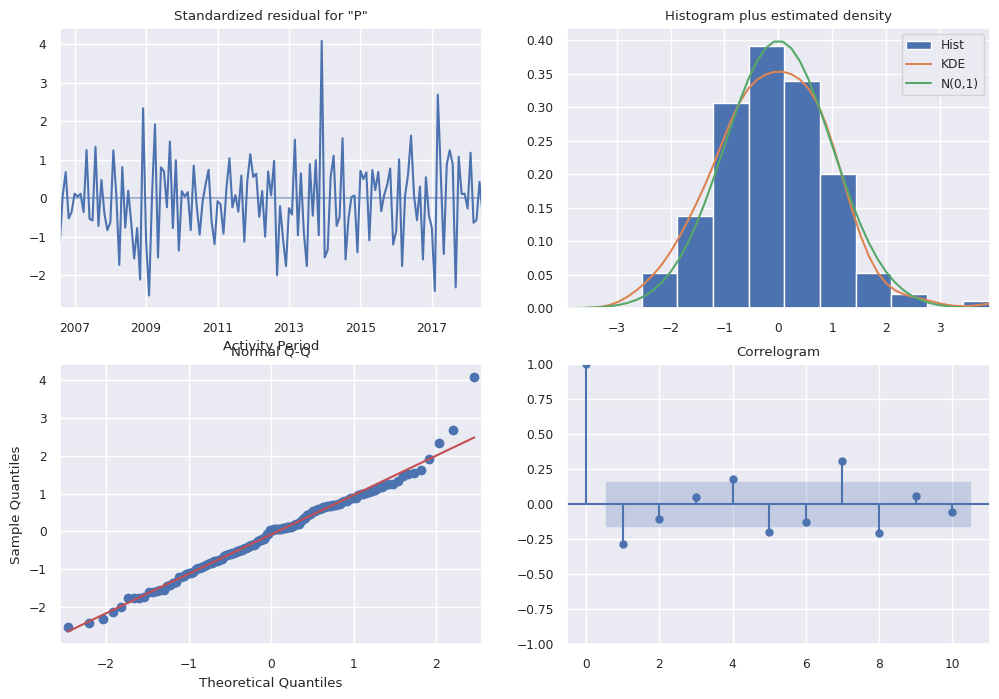

In [ ]:
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()
plt.show()

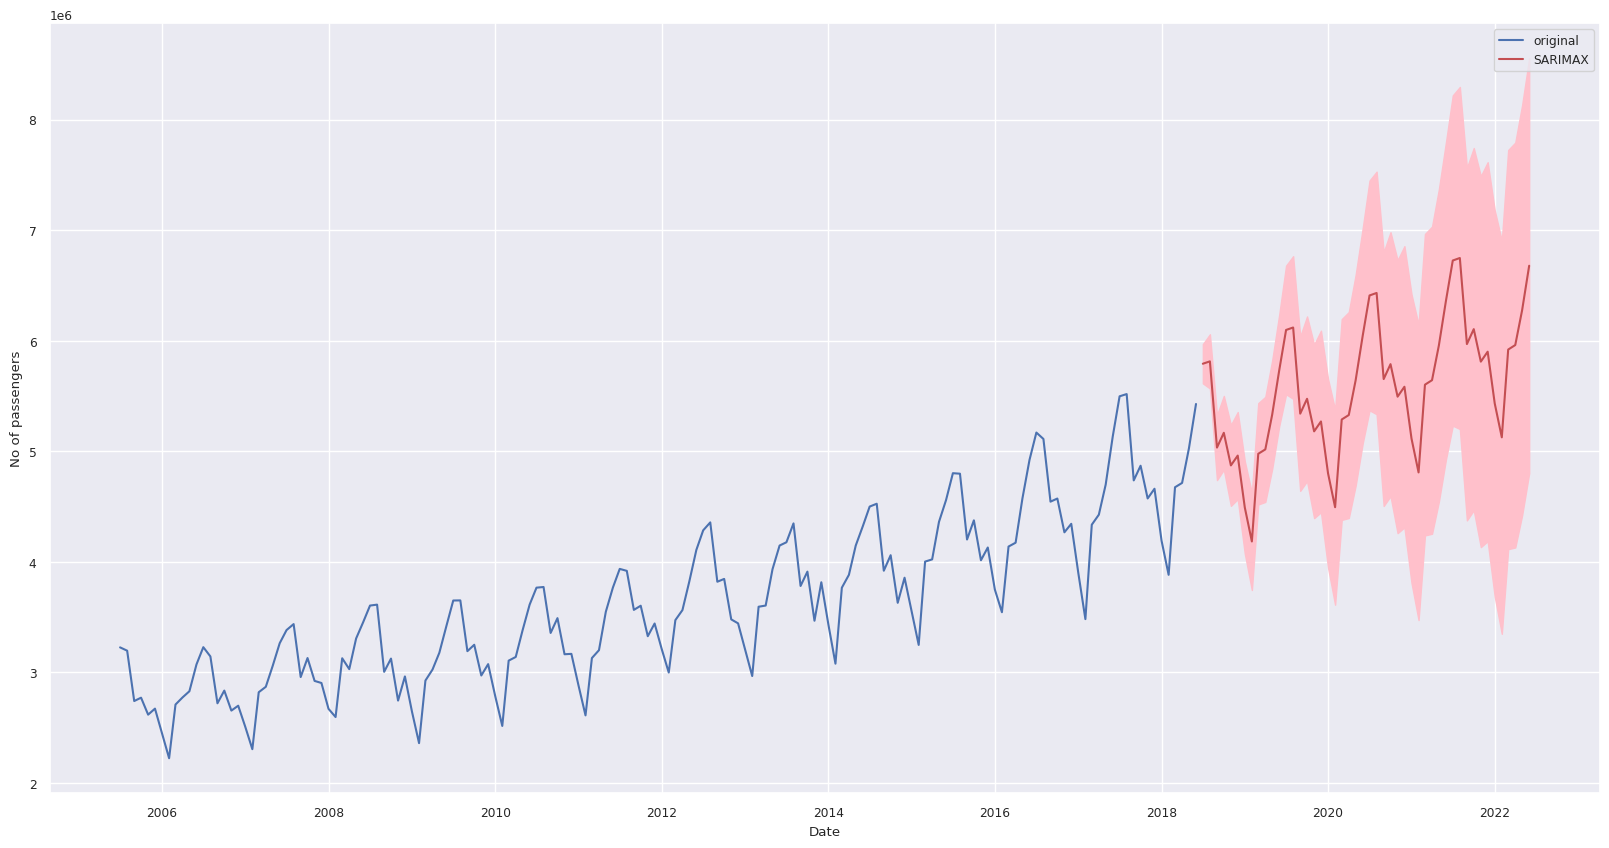

In [ ]:
forecast = results.get_forecast(steps=48)
lower = forecast.conf_int()["lower Passenger Count"]
upper = forecast.conf_int()["upper Passenger Count"]

fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(TS1, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")
plt.fill_between(forecast.conf_int().index,
                 lower,upper,
                 color='pink')
plt.xlabel('Date')
plt.ylabel('No of passengers')
plt.legend()
plt.show()

#Future Scope

### - Our optimized SARIMA Model does not take into account the impact of covid 19
### - Intervention analysis can be done on the future data of this dataset for a comprehensive analysis of TS data